In [521]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

In [522]:
df = pd.read_spss('../data/data.sav')

In [523]:
df.shape

(1200, 276)

In [524]:
# Basic statistics on WTFACTOR
print("WTFACTOR summary statistics:")
print(f"Mean: {df['WTFACTOR'].mean():.4f}")
print(f"Median: {df['WTFACTOR'].median():.4f}")
print(f"Min: {df['WTFACTOR'].min():.4f}")
print(f"Max: {df['WTFACTOR'].max():.4f}")
print(f"Standard deviation: {df['WTFACTOR'].std():.4f}")

# Check for extreme weights
extreme_weights = df[df['WTFACTOR'] > 2.0]
print(f"\nNumber of observations with weights > 2.0: {len(extreme_weights)}")

WTFACTOR summary statistics:
Mean: 1.0000
Median: 0.9052
Min: 0.4988
Max: 4.7387
Standard deviation: 0.4276

Number of observations with weights > 2.0: 30


In [525]:
df['party'] = (df["POLPART2"] == "Sinn Féin").astype(int)

In [526]:
df.shape

(1200, 277)

Feature Engineering

In [527]:
df["reunification_support"] = (df["NIRELND2"] == "reunify with the rest of Ireland").astype(int)
df["reunification_unknown"] = (df["NIRELND2"] == "I don't know").astype(int)

In [528]:
def income_bracket(x):
    high = ["£831 or more per week", "£631-£831 per week"]
    upper_mid = ["£511-£630 per week", "£421-£510 per week"]
    lower_mid = ["£361-£420 per week", "£301-£360 per week", "£241-£300 per week"]
    low = ["£181-£240 per week", "£100-£180 per week", "Less than £100 per week"]
    if x in high:
        return "High"
    elif x in upper_mid:
        return "Upper Mid"
    elif x in lower_mid:
        return "Lower Mid"
    elif x in low:
        return "Low"
    else:
        return "Unknown"

df["income_group"] = df["PERSINC3"].apply(income_bracket)
df = pd.get_dummies(df, columns=["income_group"], drop_first=True)

In [529]:
df['INCDIFF'].value_counts()

INCDIFF
Agree                         347
Strongly agree                321
Disagree                      227
Neither agree nor disagree    207
Strongly disagree              58
I don't know                   38
Name: count, dtype: int64

In [530]:
incdiff_scale = {
    "Strongly disagree": 1,
    "Disagree": 2,
    "Neither agree nor disagree": 3,
    "Agree": 4,
    "Strongly agree": 5, 
}

df["redistribution_support"] = df["INCDIFF"].map(incdiff_scale)
df["redistribution_unknown"] = (df["INCDIFF"] == "I don't know").astype(int)

In [531]:
df['redistribution_centered'] = df['redistribution_support'] - df['redistribution_support'].mean()
df['redistribution_x_reunification'] = df['reunification_support'] * df['redistribution_centered']

In [532]:
qual_map = {
    "No qualifications": 1,
    "GCSE grades D to G or equivalent": 2,
    "GCSE grades A to C or equivalent": 3,
    "GCE A level or equivalent": 4,
    "Higher education – diploma or equivalent": 5,
    "Degree level or higher": 6,
    'Other qualifications: level unknown': 3.5
}
df["education_score"] = df["HIGHQUAL2"].map(qual_map).astype(float)

In [533]:
df = df.dropna(subset=['education_score', 'redistribution_centered', 'redistribution_x_reunification'])

In [534]:
df = pd.get_dummies(df, columns=["RAGECAT"], drop_first=True)

In [535]:
X = df[[
    "reunification_support", 
    "reunification_unknown",
    "redistribution_centered",
    "redistribution_unknown",
    "redistribution_x_reunification",
    "education_score", 
    "income_group_Upper Mid", 
    "income_group_Lower Mid", 
    "income_group_Low", 
    "RAGECAT_25-34",
    "RAGECAT_35-44",
    "RAGECAT_45-54",
    "RAGECAT_55-64",
    "RAGECAT_65+"
]]

y = (df["party"]).astype(int)

In [536]:
X.isna().sum()

reunification_support             0
reunification_unknown             0
redistribution_centered           0
redistribution_unknown            0
redistribution_x_reunification    0
education_score                   0
income_group_Upper Mid            0
income_group_Lower Mid            0
income_group_Low                  0
RAGECAT_25-34                     0
RAGECAT_35-44                     0
RAGECAT_45-54                     0
RAGECAT_55-64                     0
RAGECAT_65+                       0
dtype: int64

In [537]:
X.dtypes

reunification_support               int64
reunification_unknown               int64
redistribution_centered           float64
redistribution_unknown              int64
redistribution_x_reunification    float64
education_score                   float64
income_group_Upper Mid               bool
income_group_Lower Mid               bool
income_group_Low                     bool
RAGECAT_25-34                        bool
RAGECAT_35-44                        bool
RAGECAT_45-54                        bool
RAGECAT_55-64                        bool
RAGECAT_65+                          bool
dtype: object

In [538]:
bool_columns = X.select_dtypes(include='bool').columns
X[bool_columns] = X[bool_columns].astype(int)

/var/folders/ll/gtcbtj4n6mjf4mwvq3711yw40000gn/T/ipykernel_4489/2134705148.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[bool_columns] = X[bool_columns].astype(int)


In [539]:
X = sm.add_constant(X) # add intercept

In [540]:
model = sm.GLM(y, X, family=sm.families.Binomial(), var_weights=df['WTFACTOR'])
result = model.fit()
print(result.summary2())

                      Results: Generalized linear model
Model:                   GLM                   AIC:                 879.3381  
Link Function:           Logit                 BIC:                 -7138.5726
Dependent Variable:      party                 Log-Likelihood:      -425.67   
Date:                    2025-04-30 17:59      LL-Null:             -563.85   
No. Observations:        1148                  Deviance:            851.34    
Df Model:                13                    Pearson chi2:        1.09e+03  
Df Residuals:            1134                  Scale:               1.0000    
Method:                  IRLS                                                 
------------------------------------------------------------------------------
                                Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
------------------------------------------------------------------------------
const                          -2.0773   0.4513 -4.6029 0.0000 -2.9619 -1.1

In [541]:
with open("../output/model_summary.txt", "w") as f:
    f.write(result.summary().as_text())

In [542]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each predictor (check multicolinearity)
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

                          Variable        VIF
0                            const  39.311029
1            reunification_support   1.177594
2            reunification_unknown   1.078717
3          redistribution_centered   1.490914
4           redistribution_unknown        NaN
5   redistribution_x_reunification   1.455757
6                  education_score   1.177146
7           income_group_Upper Mid   1.233622
8           income_group_Lower Mid   1.264451
9                 income_group_Low   1.330735
10                   RAGECAT_25-34   3.749155
11                   RAGECAT_35-44   3.966340
12                   RAGECAT_45-54   4.556427
13                   RAGECAT_55-64   4.766211
14                     RAGECAT_65+   5.488051


/Users/willmayer/Desktop/desktop/post_visit_analysis/.venv/lib/python3.13/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


important predictors are not multicolinear

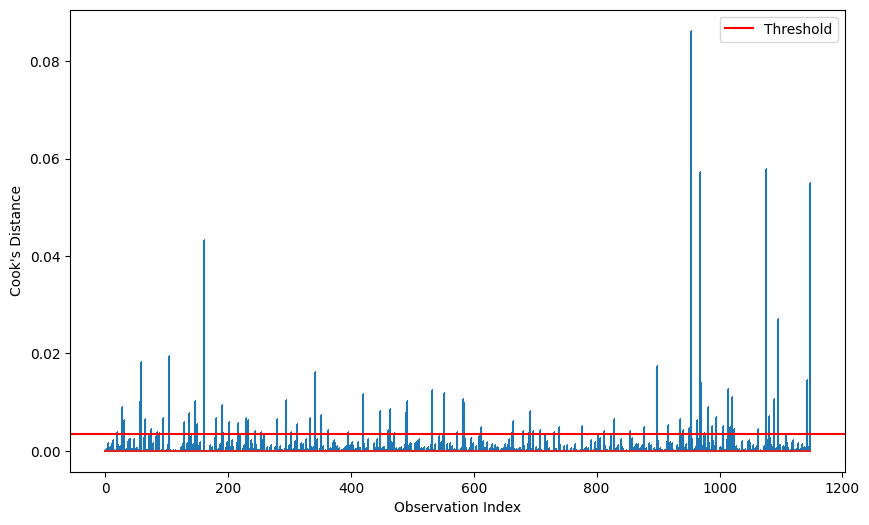

In [543]:
# Calculate influence measures
influence = result.get_influence()
cooks_d = influence.cooks_distance[0]

# Plot Cook's distance
plt.figure(figsize=(10, 6))
plt.stem(range(len(cooks_d)), cooks_d, markerfmt=",")
plt.axhline(y=4/len(X), color='r', linestyle='-', label="Threshold")
plt.xlabel("Observation Index")
plt.ylabel("Cook's Distance")
plt.legend()
plt.show()

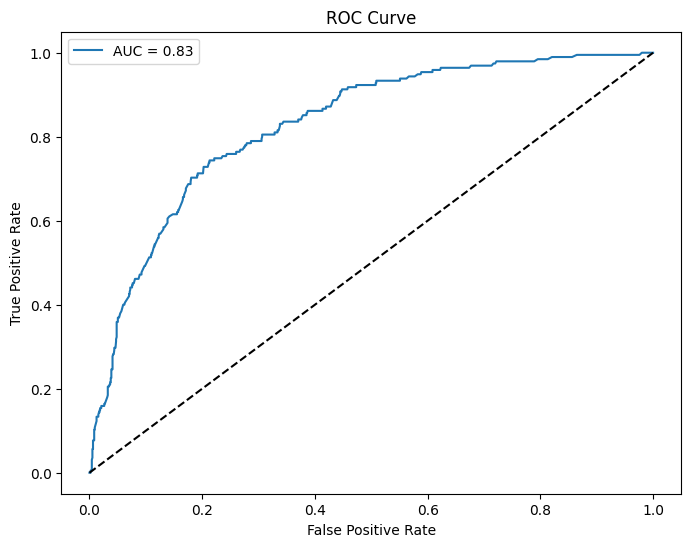

              precision    recall  f1-score   support

           0       0.88      0.95      0.91       953
           1       0.60      0.35      0.45       195

    accuracy                           0.85      1148
   macro avg       0.74      0.65      0.68      1148
weighted avg       0.83      0.85      0.83      1148


Confusion Matrix:
[[907  46]
 [126  69]]


In [544]:
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix

# Predict probabilities
y_pred_proba = result.predict(X)
y_pred = (y_pred_proba > 0.5).astype(int)

# ROC curve
fpr, tpr, _ = roc_curve(y, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Classification metrics
print(classification_report(y, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y, y_pred))

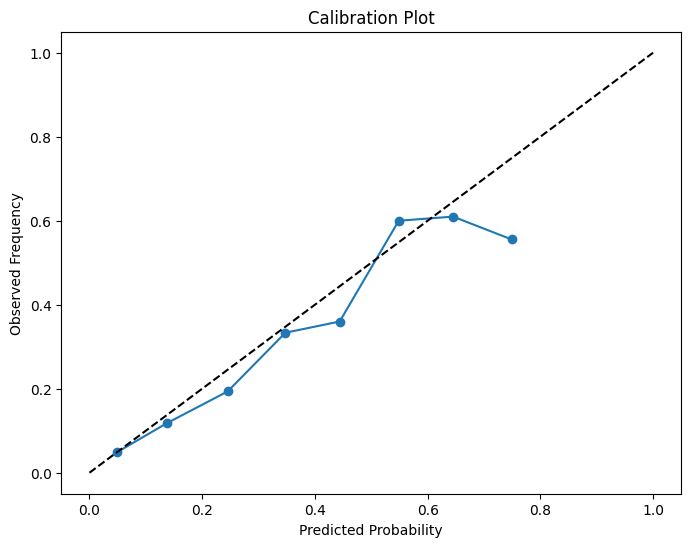

In [545]:
# Create calibration plot
from sklearn.calibration import calibration_curve

y_pred_proba = result.predict(X)
prob_true, prob_pred = calibration_curve(y, y_pred_proba, n_bins=10)

plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Predicted Probability')
plt.ylabel('Observed Frequency')
plt.title('Calibration Plot')
plt.show()

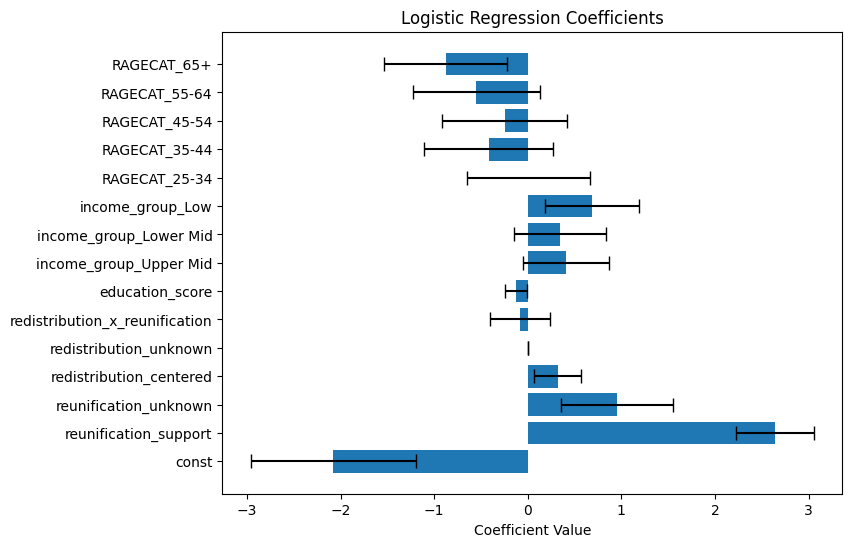

In [546]:
import matplotlib.pyplot as plt

# Get the coefficients and their confidence intervals
coef = result.params
conf_int = result.conf_int()

# Create a bar plot of coefficients
plt.figure(figsize=(8, 6))
plt.barh(coef.index, coef.values, xerr=(conf_int[1] - coef.values), capsize=5)
plt.xlabel('Coefficient Value')
plt.title('Logistic Regression Coefficients')
plt.show()

In [547]:
import nbformat
from nbconvert import PythonExporter

with open("analysis.ipynb", "r", encoding="utf-8") as f:
    nb = nbformat.read(f, as_version=4)

exporter = PythonExporter()
script, _ = exporter.from_notebook_node(nb)

with open("script.py", "w", encoding="utf-8") as f:
    f.write(script)

Visualizations

/var/folders/ll/gtcbtj4n6mjf4mwvq3711yw40000gn/T/ipykernel_4489/1658002151.py:41: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate('*', (plot_df['Odds Ratio'][i], i), fontsize=14, color='blue')


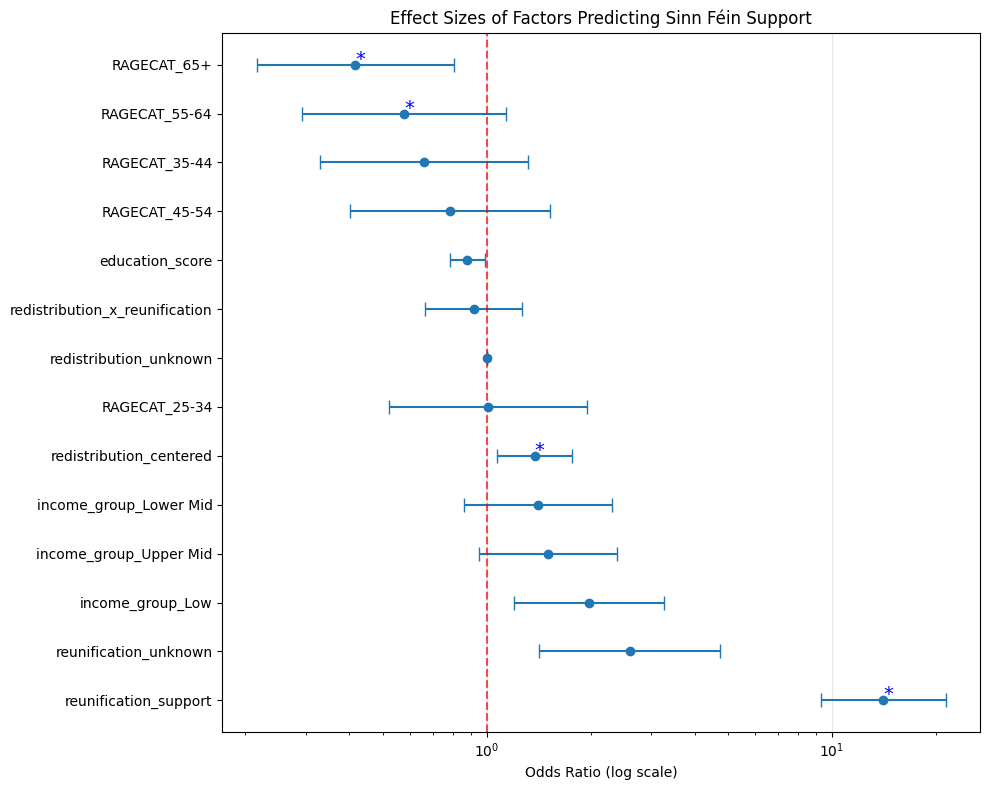

In [548]:
# Calculate odds ratios and confidence intervals
odds_ratios = np.exp(result.params)
conf_int_exp = np.exp(result.conf_int())

# Create a DataFrame for plotting
plot_df = pd.DataFrame({
    'Odds Ratio': odds_ratios,
    'Lower CI': conf_int_exp[0],
    'Upper CI': conf_int_exp[1]
})

# Remove constant
plot_df = plot_df.drop('const')

# Sort by odds ratio
plot_df = plot_df.sort_values('Odds Ratio', ascending=False)

# Create horizontal error bars for odds ratios
plt.figure(figsize=(10, 8))
plt.errorbar(
    plot_df['Odds Ratio'], 
    range(len(plot_df)), 
    xerr=[plot_df['Odds Ratio'] - plot_df['Lower CI'], plot_df['Upper CI'] - plot_df['Odds Ratio']],
    fmt='o',
    capsize=5
)

# Add a vertical line at odds ratio = 1 (no effect)
plt.axvline(x=1, color='red', linestyle='--', alpha=0.7)

# Add labels and formatting
plt.yticks(range(len(plot_df)), plot_df.index)
plt.xscale('log')  # Log scale makes comparison easier
plt.xlabel('Odds Ratio (log scale)')
plt.title('Effect Sizes of Factors Predicting Sinn Féin Support')
plt.grid(axis='x', alpha=0.3)

# Annotate significant effects
for i, var in enumerate(plot_df.index):
    if var in ['reunification_support', 'redistribution_centered', 'RAGECAT_55-64', 'RAGECAT_65+']:
        plt.annotate('*', (plot_df['Odds Ratio'][i], i), fontsize=14, color='blue')

plt.tight_layout()
plt.savefig('../output/odds_ratios.png', dpi=300)
plt.show()

In [549]:
X.dtypes

const                             float64
reunification_support               int64
reunification_unknown               int64
redistribution_centered           float64
redistribution_unknown              int64
redistribution_x_reunification    float64
education_score                   float64
income_group_Upper Mid              int64
income_group_Lower Mid              int64
income_group_Low                    int64
RAGECAT_25-34                       int64
RAGECAT_35-44                       int64
RAGECAT_45-54                       int64
RAGECAT_55-64                       int64
RAGECAT_65+                         int64
dtype: object

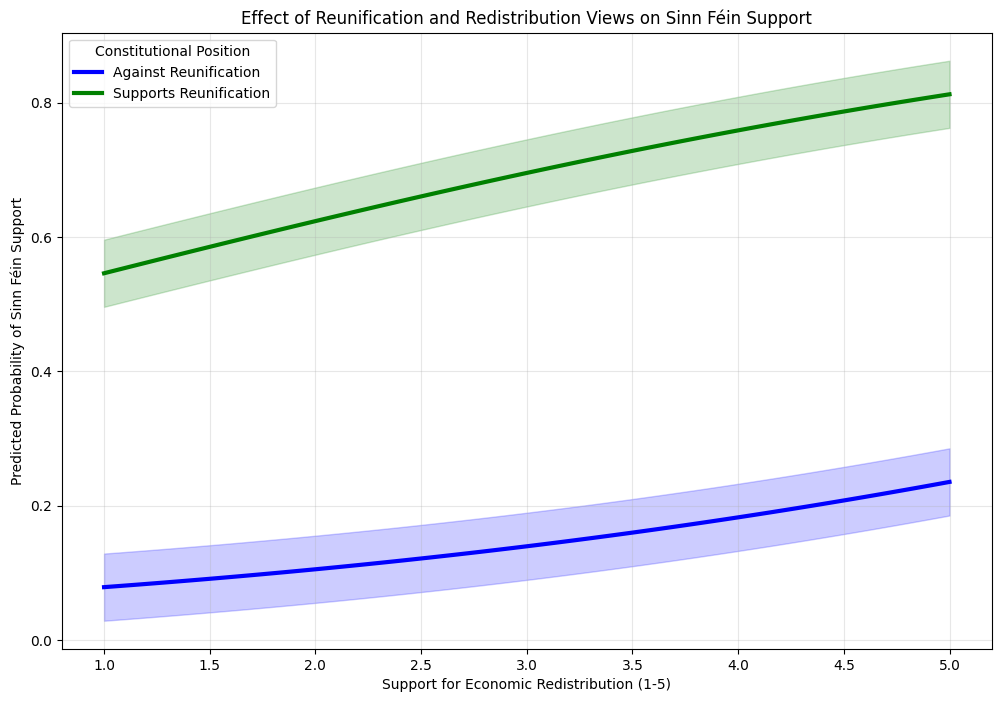

In [550]:
# Create grid for predictions
redistribution_values = np.linspace(1, 5, 100)
grid_data = []

# For each reunification value and redistribution score
for reun in [0, 1]:
    for redist in redistribution_values:
        # Create a row with mean values for other predictors
        row = X.mean().to_dict()
        row['reunification_support'] = reun
        row['redistribution_centered'] = redist
        grid_data.append(row)

# Convert to DataFrame
prediction_grid = pd.DataFrame(grid_data)

# Calculate predicted probabilities
prediction_grid['probability'] = result.predict(prediction_grid)

# Create groups for plotting
prediction_grid['Reunification Support'] = prediction_grid['reunification_support'].map({
    0: 'Against Reunification', 
    1: 'Supports Reunification'
})

# Plot
plt.figure(figsize=(12, 8))
sns.lineplot(
    data=prediction_grid, 
    x='redistribution_centered', 
    y='probability', 
    hue='Reunification Support',
    palette=['blue', 'green'],
    linewidth=3
)

plt.fill_between(
    prediction_grid[prediction_grid['reunification_support']==0]['redistribution_centered'],
    prediction_grid[prediction_grid['reunification_support']==0]['probability'] - 0.05,
    prediction_grid[prediction_grid['reunification_support']==0]['probability'] + 0.05,
    color='blue', alpha=0.2
)

plt.fill_between(
    prediction_grid[prediction_grid['reunification_support']==1]['redistribution_centered'],
    prediction_grid[prediction_grid['reunification_support']==1]['probability'] - 0.05,
    prediction_grid[prediction_grid['reunification_support']==1]['probability'] + 0.05,
    color='green', alpha=0.2
)

plt.xlabel('Support for Economic Redistribution (1-5)')
plt.ylabel('Predicted Probability of Sinn Féin Support')
plt.title('Effect of Reunification and Redistribution Views on Sinn Féin Support')
plt.grid(alpha=0.3)
plt.legend(title='Constitutional Position')
plt.savefig('../output/predicted_probabilities.png', dpi=300)
plt.show()

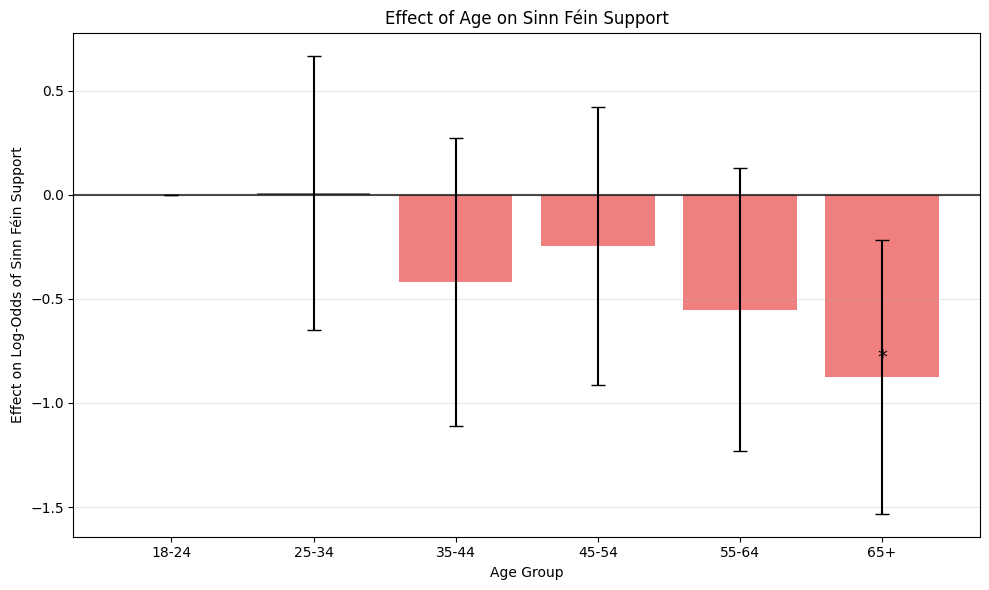

In [551]:
# Create age category labels and values from your categories
age_categories = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']
age_coeffs = [0] + [result.params[f'RAGECAT_{cat}'] for cat in age_categories[1:]]

# Create DataFrame for plotting
age_df = pd.DataFrame({
    'Age Group': age_categories,
    'Coefficient': age_coeffs,
    'Lower CI': [0] + [result.conf_int()[0][f'RAGECAT_{cat}'] for cat in age_categories[1:]],
    'Upper CI': [0] + [result.conf_int()[1][f'RAGECAT_{cat}'] for cat in age_categories[1:]]
})

# Plot
plt.figure(figsize=(10, 6))
plt.bar(age_df['Age Group'], age_df['Coefficient'], color=['grey' if c >= 0 else 'lightcoral' for c in age_df['Coefficient']])
plt.errorbar(age_df['Age Group'], age_df['Coefficient'], 
             yerr=[age_df['Coefficient'] - age_df['Lower CI'], age_df['Upper CI'] - age_df['Coefficient']],
             fmt='none', color='black', capsize=5)

# Add horizontal line at y=0
plt.axhline(y=0, color='black', linestyle='-', alpha=0.7)

# Add labels
plt.xlabel('Age Group')
plt.ylabel('Effect on Log-Odds of Sinn Féin Support')
plt.title('Effect of Age on Sinn Féin Support')
plt.grid(axis='y', alpha=0.3)

# Mark significant effects
for i, row in age_df.iterrows():
    if (row['Lower CI'] < 0 and row['Upper CI'] < 0) or (row['Lower CI'] > 0 and row['Upper CI'] > 0):
        plt.annotate('*', (i, row['Coefficient']), textcoords="offset points", 
                    xytext=(0,10), ha='center', fontsize=14)

plt.tight_layout()
plt.savefig('../output/age_effects.png', dpi=300)
plt.show()

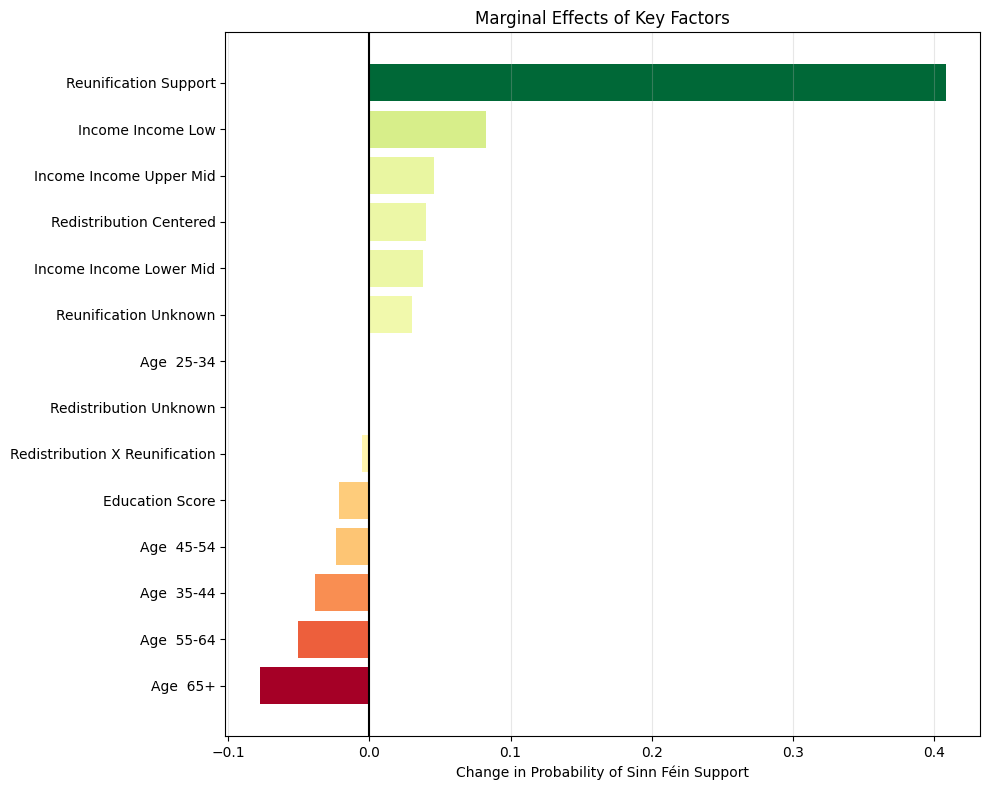

In [552]:
def get_marginal_effects(result, X):
    # Base probabilities using mean values
    base_x = X.mean().to_dict()
    
    effects = {}
    
    # For each predictor
    for var in X.columns:
        if var == 'const':
            continue
            
        # For binary variables
        if var in ['reunification_support'] or var.startswith('RAGECAT_') or var.startswith('income_group_'):
            # Calculate effect as P(Y=1|X=1) - P(Y=1|X=0)
            x_0 = base_x.copy()
            x_1 = base_x.copy()
            
            x_0[var] = 0
            x_1[var] = 1
            
            prob_0 = result.predict(pd.DataFrame([x_0]))[0]
            prob_1 = result.predict(pd.DataFrame([x_1]))[0]
            
            effects[var] = prob_1 - prob_0
            
        # For continuous variables
        else:
            # Increase by one standard deviation
            x_high = base_x.copy()
            x_high[var] = base_x[var] + X[var].std()
            
            # Decrease by one standard deviation
            x_low = base_x.copy()
            x_low[var] = base_x[var] - X[var].std()
            
            prob_high = result.predict(pd.DataFrame([x_high]))[0]
            prob_low = result.predict(pd.DataFrame([x_low]))[0]
            
            effects[var] = (prob_high - prob_low) / 2
    
    return effects

# Get marginal effects
marg_effects = get_marginal_effects(result, X)
marg_df = pd.DataFrame({'Variable': list(marg_effects.keys()), 
                        'Marginal Effect': list(marg_effects.values())})

# Clean up variable names for display
marg_df['Variable'] = marg_df['Variable'].str.replace('_', ' ').str.title()
marg_df['Variable'] = marg_df['Variable'].str.replace('Ragecat', 'Age ')
marg_df['Variable'] = marg_df['Variable'].str.replace('Group', 'Income')

# Sort by absolute effect size
marg_df = marg_df.sort_values('Marginal Effect', ascending=True)
# Plot
plt.figure(figsize=(10, 8))
# colors = ['green' if x > 0 else 'red' for x in marg_df['Marginal Effect']]
norm = mcolors.TwoSlopeNorm(vmin=marg_df['Marginal Effect'].min(),
                            vcenter=0,
                            vmax=marg_df['Marginal Effect'].max())

# Create a diverging colormap: reds for negative, greens for positive
cmap = plt.cm.RdYlGn  # Red -> Yellow -> Green
# Get colors
colors = cmap(norm(marg_df['Marginal Effect']))

plt.barh(marg_df['Variable'], marg_df['Marginal Effect'], color=colors)
plt.axvline(x=0, color='black', linestyle='-')
plt.xlabel('Change in Probability of Sinn Féin Support')
plt.title('Marginal Effects of Key Factors')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('../output/marginal_effects.png', dpi=300)
plt.show()

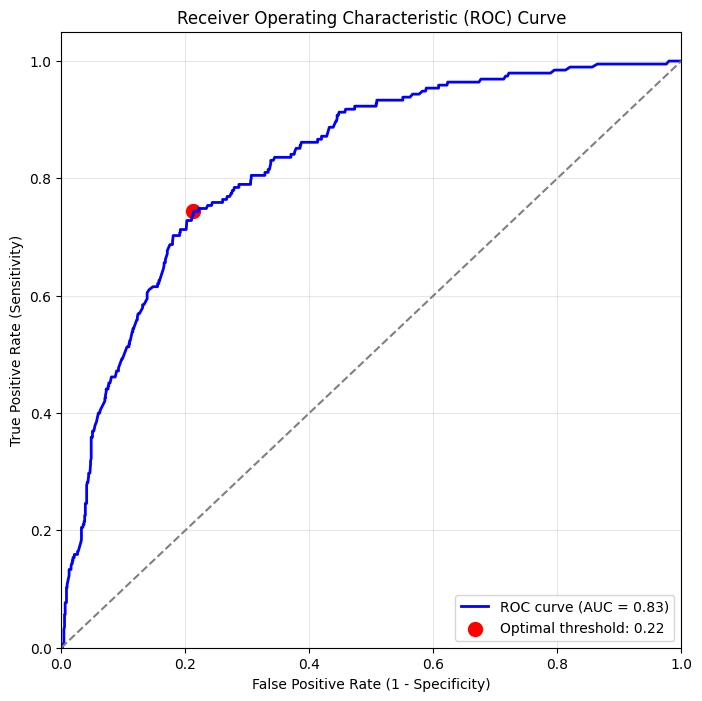

In [553]:
from sklearn.metrics import roc_curve, roc_auc_score

# Get predictions
y_pred_proba = result.predict(X)

# Calculate ROC curve points
fpr, tpr, thresholds = roc_curve(y, y_pred_proba)
auc = roc_auc_score(y, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Add annotation for the optimal threshold
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
plt.scatter(fpr[ix], tpr[ix], marker='o', color='red', s=100, 
            label=f'Optimal threshold: {thresholds[ix]:.2f}')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.savefig('../output/roc_curve.png', dpi=300)
plt.show()

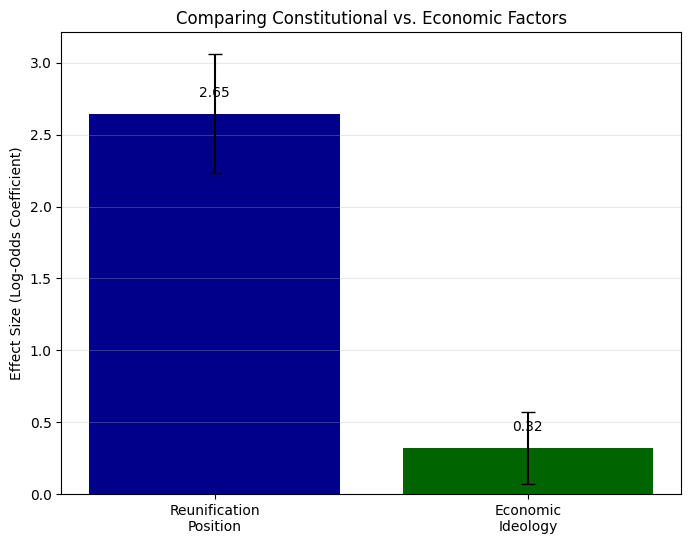

In [554]:
# Create a DataFrame for comparison
comparison_df = pd.DataFrame({
    'Factor': ['Reunification\nPosition', 'Economic\nIdeology'],
    'Coefficient': [result.params['reunification_support'], result.params['redistribution_centered']],
    'Lower CI': [result.conf_int()[0]['reunification_support'], result.conf_int()[0]['redistribution_centered']],
    'Upper CI': [result.conf_int()[1]['reunification_support'], result.conf_int()[1]['redistribution_centered']]
})

# Plot comparative bar chart
plt.figure(figsize=(8, 6))
bars = plt.bar(comparison_df['Factor'], comparison_df['Coefficient'], color=['darkblue', 'darkgreen'])
plt.errorbar(comparison_df['Factor'], comparison_df['Coefficient'],
             yerr=[comparison_df['Coefficient'] - comparison_df['Lower CI'], 
                   comparison_df['Upper CI'] - comparison_df['Coefficient']],
             fmt='none', color='black', capsize=5)

# Add values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{height:.2f}', ha='center', va='bottom')

plt.ylabel('Effect Size (Log-Odds Coefficient)')
plt.title('Comparing Constitutional vs. Economic Factors')
plt.grid(axis='y', alpha=0.3)
plt.savefig('../output/factor_comparison.png', dpi=300)
plt.show()

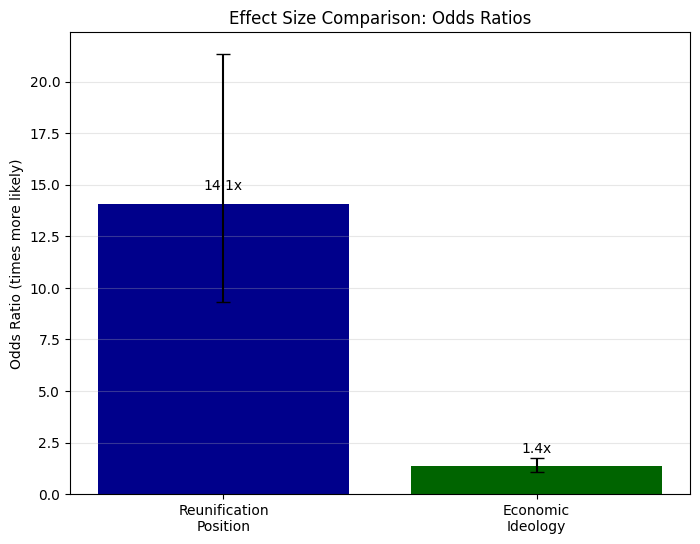

In [555]:
# Create comparative odds ratio chart
plt.figure(figsize=(8, 6))
odds_ratios = np.exp(comparison_df['Coefficient'])
or_lower = np.exp(comparison_df['Lower CI'])
or_upper = np.exp(comparison_df['Upper CI'])

bars = plt.bar(comparison_df['Factor'], odds_ratios, color=['darkblue', 'darkgreen'])
plt.errorbar(comparison_df['Factor'], odds_ratios,
             yerr=[odds_ratios - or_lower, or_upper - odds_ratios],
             fmt='none', color='black', capsize=5)

# Add values on top of bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{height:.1f}x', ha='center', va='bottom')

plt.ylabel('Odds Ratio (times more likely)')
plt.title('Effect Size Comparison: Odds Ratios')
plt.grid(axis='y', alpha=0.3)
plt.savefig('../output/odds_ratio_comparison.png', dpi=300)
plt.show()

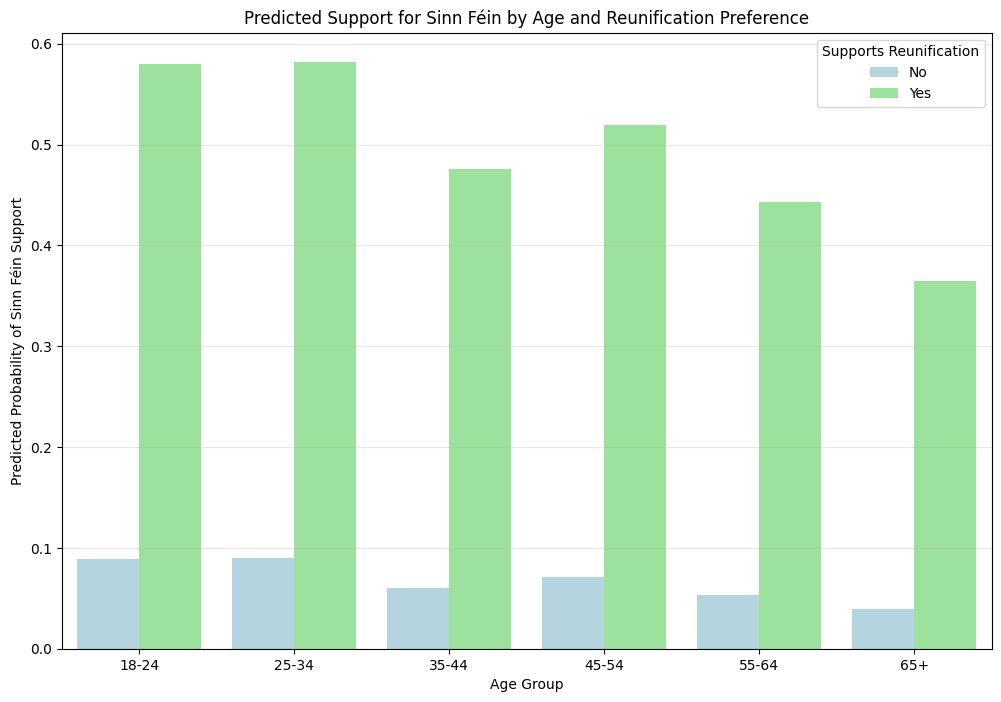

In [556]:
# Calculate predicted probabilities by age and reunification support
age_groups = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']
predictions = []

for age in age_groups:
    for reun in [0, 1]:
        # Create prediction data
        pred_data = X.mean().to_dict()
        
        # Set age dummy variables
        for ag in age_groups[1:]:  # Skip reference category
            pred_data[f'RAGECAT_{ag}'] = 1 if ag == age and age != '18-24' else 0
            
        pred_data['reunification_support'] = reun
        
        # Calculate probability
        prob = result.predict(pd.DataFrame([pred_data]))[0]
        
        predictions.append({
            'Age Group': age,
            'Reunification Support': 'Yes' if reun == 1 else 'No',
            'Probability': prob
        })

# Convert to DataFrame for plotting
pred_df = pd.DataFrame(predictions)

# Create the plot
plt.figure(figsize=(12, 8))
sns.barplot(x='Age Group', y='Probability', hue='Reunification Support', 
            data=pred_df, palette=['lightblue', 'lightgreen'])

plt.xlabel('Age Group')
plt.ylabel('Predicted Probability of Sinn Féin Support')
plt.title('Predicted Support for Sinn Féin by Age and Reunification Preference')
plt.grid(axis='y', alpha=0.3)
plt.legend(title='Supports Reunification')
plt.savefig('../output/age_reunification_support.png', dpi=300)
plt.show()

In [557]:
(df['redistribution_support'] * df['WTFACTOR']).sum() / df['WTFACTOR'].sum()

np.float64(3.604572063605617)